# Question 4
### Reproduce Figure 1 in the paper. When doing that, try to slice data using `xarray` in the most clear and reproducible way (for example, don't use indices to access data objects like we did in the example above).

In [78]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import fsspec

import xarray as xr
xr.set_options(display_style="html")  # display dataset nicely

import warnings
warnings.simplefilter("ignore")  # filter some warning messages

# code features from https://scitools.org.uk/cartopy/docs/v0.14/matplotlib/feature_interface.html
crs = ccrs.PlateCarree()  # set projection

In [79]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

from pathlib import Path

# Small style adjustments for more readable plots
plt.style.use("seaborn-whitegrid")
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["font.size"] = 14

In [80]:
ds = xr.open_dataset("~/shared/climate-data/ds_hw.nc")
ds

<xarray.Dataset>
Dimensions:           (time: 6443, lat: 251, lon: 234)
Coordinates:
  * lat               (lat) float32 33.0 33.06 33.12 33.18 ... 47.88 47.94 48.0
  * lon               (lon) float32 -132.0 -131.9 -131.9 ... -118.1 -118.0
  * time              (time) datetime64[ns] 2002-06-01T09:00:00 ... 2020-01-2...
Data variables:
    analysed_sst      (time, lat, lon) float32 ...
    analysis_error    (time, lat, lon) float32 ...
    mask              (time, lat, lon) float32 ...
    sea_ice_fraction  (time, lat, lon) float32 ...
Attributes: (12/47)
    Conventions:                CF-1.7
    Metadata_Conventions:       Unidata Observation Dataset v1.0
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    comment:                    MUR = "Multi-scale Ultra-high Resolution"
    creator_email:              ghrsst@podaac.jpl.nasa.gov
    ...                         ...
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    time_coverage_end:          20200116T210000Z
    time_coverage_start:        20200115T210000Z
    title:                      Daily MUR SST, Final product
    uuid:                       27665bc0-d5fc-11e1-9b23-0800200c9a66
    westernmost_longitude:      -180.0

In [81]:
temp = ds.analysed_sst

In [82]:
#2002-2012 Data
temp_2002_2012 = temp.sel(time = slice("2002","2012"))

In [83]:
#2002-2012 mean grouped by month
temp_mean_2002_2012 = temp_2002_2012.groupby('time.month').mean('time')

In [84]:
#2002-2012 sd grouped by month
temp_SD_2002_2012 = temp_2002_2012.groupby('time.month').std('time')

In [85]:
#2014-2016 Data
temp_2014_2016 = temp.sel(time = slice("2014","2016"))

In [86]:
#2014-2016 monthly mean
temp_monthly_mean_2014_2016 = temp_2014_2016.resample(time='M').mean()

In [87]:
#2014-2016 monthly SD
temp_monthly_SD_2014_2016 = temp_2014_2016.resample(time='M').std()

In [88]:
#anomaly_2014
anomaly_2014 = []
for month_2014, month in zip(range(0,12), range(0,12)):
        anomaly_per_month_2014 = temp_monthly_mean_2014_2016[month_2014] - temp_mean_2002_2012[month]
        anomaly_2014.append(anomaly_per_month_2014)
        combined_2014 = xr.concat(anomaly_2014, dim='month')

In [89]:
#anomaly SD 2014
anomaly_SD_2014 = []
for month_2014, month in zip(range(0,12), range(0,12)):
        anomaly_SD_per_month_2014 = temp_monthly_SD_2014_2016[month_2014] - temp_SD_2002_2012[month]
        anomaly_SD_2014.append(anomaly_per_month_2014)
        combined_SD_2014 = xr.concat(anomaly_SD_2014, dim='month')

In [100]:
#anomaly_2015
anomaly_2015 = []
for month_2015, month in zip(range(12,24), range(0,12)):
        anomaly_per_month_2015 = temp_monthly_mean_2014_2016[month_2015] - temp_mean_2002_2012[month]
        anomaly_2015.append(anomaly_per_month_2015)
        combined_2015 = xr.concat(anomaly_2015, dim='month')

In [108]:
#anomaly SD 2015
anomaly_SD_2015 = []
for month_2015, month in zip(range(0,12), range(0,12)):
        anomaly_SD_per_month_2015 = temp_monthly_SD_2014_2016[month_2015] - temp_SD_2002_2012[month]
        anomaly_SD_2015.append(anomaly_per_month_2015)
        combined_SD_2015 = xr.concat(anomaly_SD_2015, dim='month')

In [92]:
#anomaly_2016
anomaly_2016 = []
for month_2016, month in zip(range(24,36), range(0,12)):
        anomaly_per_month_2016 = temp_monthly_mean_2014_2016[month_2016] - temp_mean_2002_2012[month]
        anomaly_2016.append(anomaly_per_month_2016)
        combined_2016 = xr.concat(anomaly_2016, dim='month')

In [93]:
#anomaly SD 2016
anomaly_SD_2016 = []
for month_2016, month in zip(range(0,12), range(0,12)):
        anomaly_SD_per_month_2016 = temp_monthly_SD_2014_2016[month_2016] - temp_SD_2002_2012[month]
        anomaly_SD_2016.append(anomaly_per_month_2016)
        combined_SD_2016 = xr.concat(anomaly_SD_2016, dim='month')

(Text(0.5, 0, ''), Text(0, 0.5, ''))

<Figure size 800x600 with 0 Axes>

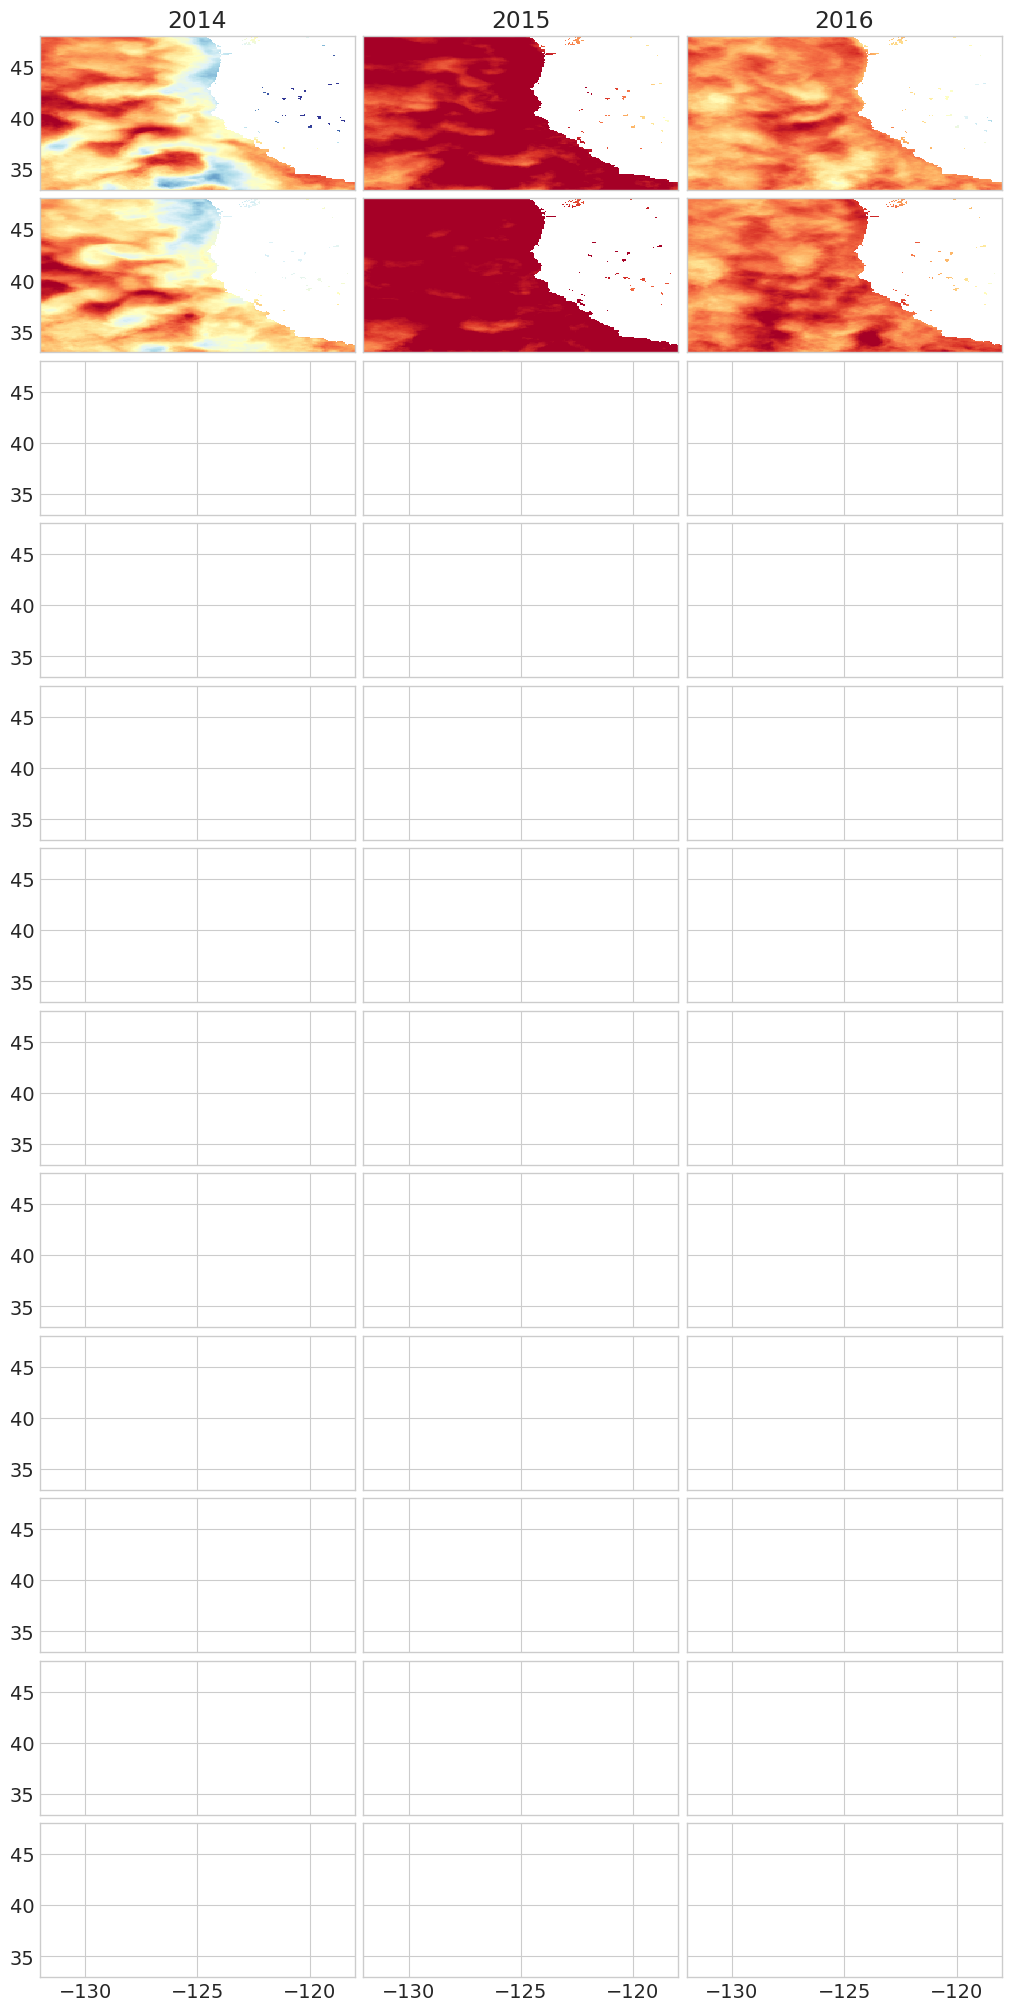

In [127]:
plt.figure()
axes = plt.subplots(nrows=12, ncols=3, figsize=(10, 20),layout="constrained", sharex = True, sharey=True)
#cmap = plt.get_cmap("RdYlBu")
levels = np.linspace(-2, 2, 21)
plt.subplots_adjust(left=0, hspace=.215, wspace=-.77)

plt.subplot(12,3,1)
#combined_2014[0] = combined_2014[0].where(combined_2014[0]<combined_SD_2014[0], np.nan)
combined_2014[0].plot(add_colorbar=False, cmap = 'RdYlBu_r',vmin=-2, vmax=2)
ax = plt.gca()
ax.set_title('2014')
plt.xlabel(''), plt.ylabel('')

plt.subplot(12,3,2)
combined_2015[0].plot(add_colorbar=False, cmap = 'RdYlBu_r',vmin=-2, vmax=2)
ax = plt.gca()
ax.set_title('2015')
plt.xlabel(''), plt.ylabel('')

plt.subplot(12,3,3)
combined_2016[0].plot(add_colorbar=False, cmap = 'RdYlBu_r',vmin=-2, vmax=2)
ax = plt.gca()
ax.set_title('2016')
plt.xlabel(''), plt.ylabel('')

plt.subplot(12,3,4)
combined_2014[1].plot(add_colorbar=False, cmap = 'RdYlBu_r',vmin=-2, vmax=2)
ax = plt.gca()
ax.set_title('')
plt.xlabel(''), plt.ylabel('')

plt.subplot(12,3,5)
combined_2015[1].plot(add_colorbar=False, cmap = 'RdYlBu_r',vmin=-2, vmax=2)
ax = plt.gca()
ax.set_title('')
plt.xlabel(''), plt.ylabel('')

plt.subplot(12,3,6)
combined_2016[1].plot(add_colorbar=False, cmap = 'RdYlBu_r',vmin=-2, vmax=2)
ax = plt.gca()
ax.set_title('')
plt.xlabel(''), plt.ylabel('')